In [120]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
from datetime import datetime
import re
import ast

from pandas_profiling import ProfileReport

import my_functions
import importlib
importlib.reload(my_functions)

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from scipy import stats
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [121]:
input_folder = 'input\\'
print(os.listdir("input"))


['main_task.csv']


# DATA
## Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:
* Restaurant_id — идентификационный номер ресторана / сети ресторанов;
* City — город, в котором находится ресторан;
* Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;
* Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* Price Range — диапазон цен в ресторане;
* Number of Reviews — количество отзывов о ресторане;
* Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;
* URL_TA — URL страницы ресторана на TripAdvosor;
* ID_TA — идентификатор ресторана в базе данных TripAdvisor.

In [254]:
data = pd.read_csv(input_folder + 'main_task.csv')
data.columns = data.columns.str.lower()
data.columns = [name.replace(' ', '_') for name in data.columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


# Заполняем NaN

In [267]:
data['cuisine_style'] = data['cuisine_style'].fillna('[\'not_specified\']')
data['number_of_reviews'] = data.groupby(by='city').number_of_reviews.apply(lambda x: x.fillna(round(x.mean())))

# data['price_range'] = data['price_range'].astype(str)

data['price_range_int'] = data[data.price_range.notnull()].price_range.apply(lambda x: 0 if x == '$' else 
                                                                                      (1 if x == '$$ - $$$' else 2))
price_range_group = data.groupby(by='price_range').agg({'number_of_reviews':['mean'], 'price_range': 'size'}).reset_index()
print(price_range_group)
# div = []
# for i in range(len(price_range_group) - 1):
#     div.append(np.mean([price_range_group.number_of_reviews['mean'][i], 
#                         price_range_group.number_of_reviews['mean'][i+1]]))


# data['price_range_int'] = data.number_of_reviews.apply(lambda x: 0 if x < div[0] else (2 if x > div[1] else 1) )
# data['price_range_int'].value_counts(dropna=False)
# x = '                        price_range_group.number_of_reviews[\'mean\'][i+1]]))'
# len(x)
data.groupby(by='price_range').agg({'number_of_reviews':['mean'], 'price_range': 'size'}).reset_index()

price_range number_of_reviews price_range
                           mean        size
0           $         95.236503        6279
1    $$ - $$$        186.412285       18412
2        $$$$        375.125791        1423


,price_range,number_of_reviews,price_range
,,mean,size
0,$,95.236503,6279
1,$$ - $$$,186.412285,18412
2,$$$$,375.125791,1423


In [124]:


data.drop(['restaurant_id', 'url_ta', 'id_ta'], inplace=True,  axis = 1)
data['price_range'].fillna(data.price_range.mode()[0], inplace=True)

data['cuisine_style'] = data['cuisine_style'].apply(ast.literal_eval)

data['reviews'] = data['reviews'].apply(lambda x: re.sub((r'\bnan\b'), '\'empty_voice\'', x))
data['reviews'] = data['reviews'].apply(ast.literal_eval)

data['reviews_text'] =  data['reviews'].apply(lambda x: x[0])
data['reviews_dates'] = data['reviews'].apply(lambda x: [datetime.strptime(date, '%m/%d/%Y').date() for date in x[1]])






data.head(2)

,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,reviews_text,reviews_dates,price_range_int
0,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[[Good food at your doorstep, A good hotel res...","[Good food at your doorstep, A good hotel rest...","[2017-12-31, 2017-11-20]",1
1,Stockholm,[not_specified],1537.0,4.0,$$ - $$$,10.0,"[[Unique cuisine, Delicious Nepalese food], [0...","[Unique cuisine, Delicious Nepalese food]","[2017-07-06, 2016-06-19]",1


In [125]:
set_dates = set()
data['dif_days'] = data.reviews_dates.apply(lambda x: (x[0] - x[-1]) if len(x) > 0 else pd.Timedelta('0 days') )
data['dif_days'] = data['dif_days'].dt.days

cuisine_style_set = set()
data.cuisine_style.apply(lambda x: cuisine_style_set.update(x))
cuisine_style_list = list(cuisine_style_set)
for cuisine in cuisine_style_list:
    data[cuisine] = data.cuisine_style.apply(lambda x: 1 if cuisine in x else 0)

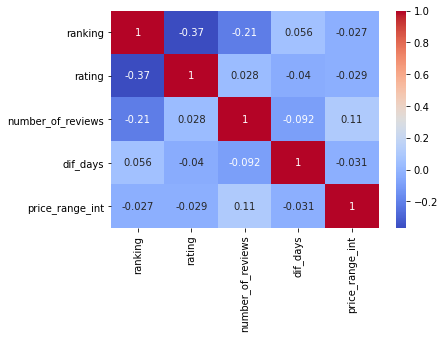

In [126]:


data.price_range.value_counts(dropna=False)

# data.groupby(by='city').agg({'price_range_int':'mean', 'city':'size'}).sort_values(by='price_range_int')
# data['price_range'] = data['price_range'].astype(str)
# data.groupby(by='price_range').agg({'city':lambda x: stats.mode(x) , 'ranking': 'mean', 'rating' : 'mean', 'number_of_reviews':'mean', 'dif_days':'mean'})

correlation = data[['ranking', 'rating', 'number_of_reviews', 'dif_days','price_range_int']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [127]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)

X = data.drop(['restaurant_id','city', 'rating', 'cuisine_style', 'price_range', 'reviews', 'url_ta', 'id_ta', 'reviews_text','reviews_dates'], axis = 1, errors='ignore')
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train

# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [128]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.35523641448412696


MAE: 0.34141057440476186